In [1]:
import os
from pathlib import Path
os.chdir("/Users/mregan/Dev/Litmus-freqtrade-temp/")
print(Path.cwd())

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

/Users/mregan/Dev/Litmus-freqtrade-temp


In [2]:
import pandas as pd
import numpy as np
from user_data.litmus import get_labeled_data
from user_data.litmus import meta_model

pd.options.display.max_columns = 400
pd.options.display.max_rows = 400

In [3]:
ld = get_labeled_data.GetLabeledData(
    timeframe='12h',
    latest=False,
    bt_filename='backtest_vulcanprimary-2022-05-01_11-51-51.json',
    bt_pkl_filename='backtest_vulcanprimary-2022-05-01_11-51-51_signals.pkl')

In [4]:
df = ld.get_all_data()
df

open    high     low  \
strategy      pair       date                                                
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  3.9949  4.4662  3.9887   
                         2021-03-17 00:00:00+00:00  4.5603  4.8100  4.2512   
                         2021-04-04 12:00:00+00:00  4.3702  4.7020  4.3340   
                         2021-04-13 12:00:00+00:00  5.4557  5.7313  5.4438   
                         2021-04-30 12:00:00+00:00  5.5725  5.6900  5.5086   
...                                                    ...     ...     ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  0.8718  0.8989  0.8416   
                         2022-01-01 12:00:00+00:00  0.8298  0.8759  0.8296   
                         2022-02-03 00:00:00+00:00  0.5715  0.5953  0.5686   
                         2022-02-16 00:00:00+00:00  0.6417  0.6948  0.6300   
                         2022-03-17 00:00:00+00:00  0.5110  0.5144  0.5028   

                                                     close       volume  \
strategy      pair       date                                             
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  4.3249  10997902.63   
                         2021-03-17 00:00:00+00:00  4.4766  10717840.77   
                         2021-04-04 12:00:00+00:00  4.5700   3971927.19   
                         2021-04-13 12:00:00+00:00  5.6116   4272484.89   
                         2021-04-30 12:00:00+00:00  5.6400   3289967.31   
...                                                    ...          ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  0.8497   2260901.00   
                         2022-01-01 12:00:00+00:00  0.8748   1954741.00   
                         2022-02-03 00:00:00+00:00  0.5944   2726652.00   
                         2022-02-16 00:00:00+00:00  0.6811   5635380.00   
                         2022-03-17 00:00:00+00:00  0.5116   1133797.00   

                                                      volume_adi  \
strategy      pair       date                                      
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  8.774016e+07   
                         2021-03-17 00:00:00+00:00  9.390124e+07   
                         2021-04-04 12:00:00+00:00  9.185711e+07   
                         2021-04-13 12:00:00+00:00  1.166959e+08   
                         2021-04-30 12:00:00+00:00  1.404404e+08   
...                                                          ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  7.841945e+07   
                         2022-01-01 12:00:00+00:00  7.991118e+07   
                         2022-02-03 00:00:00+00:00  7.528651e+07   
                         2022-02-16 00:00:00+00:00  8.687536e+07   
                         2022-03-17 00:00:00+00:00  8.268237e+07   

                                                      volume_obv  volume_cmf  \
strategy      pair       date                                                  
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  4.732082e+05    0.034775   
                         2021-03-17 00:00:00+00:00 -1.446079e+07    0.093779   
                         2021-04-04 12:00:00+00:00 -2.110222e+07    0.173375   
                         2021-04-13 12:00:00+00:00 -7.370963e+06    0.149558   
                         2021-04-30 12:00:00+00:00  1.717377e+07    0.175899   
...                                                          ...         ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  9.503496e+08    0.168347   
                         2022-01-01 12:00:00+00:00  9.534915e+08    0.031506   
                         2022-02-03 00:00:00+00:00  9.046713e+08    0.076853   
                         2022-02-16 00:00:00+00:00  9.299385e+08    0.148932   
                         2022-03-17 00:00:00+00:00  9.537537e+08    0.240490   

                                                        volume_fi  volume_em  \
strategy      pair       date                            

In [5]:
df['exit_reason'].value_counts()

lower_barrier_sl_sell          4203
upper_barrier_pt_sell          3667
vertical_barrier_force_sell    2791
force_exit                      701
Name: exit_reason, dtype: int64

In [6]:
# Tripple barrier target setting method

df['y_true'] = np.nan
df['y_true'] = np.where(df['exit_reason'].isin(['upper_barrier_pt_sell']), True, df['y_true'])
df['y_true'] = np.where(df['exit_reason'].isin(['lower_barrier_sl_sell', 'vertical_barrier_force_sell']), False, df['y_true'])
df['y_true'] = np.where(df['exit_reason'].isin(['force_exit']), np.nan, df['y_true'])
df['y_true'].value_counts()

0.0    6994
1.0    3667
Name: y_true, dtype: int64

In [7]:
df['y_pred'] = True

In [8]:
df.columns.values

array(['open', 'high', 'low', 'close', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch',
       'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index',
       'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
       'trend_ichimoku_conv', 'trend

In [9]:
# Train ML model to predict 'correct_trade'

features_num = [
       'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch',
       'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index',
       'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
       'trend_stc', 'trend_adx', 'trend_adx_pos',
       'trend_adx_neg', 'trend_cci', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind', 'trend_psar_up', 'trend_psar_down',
       'trend_psar_up_indicator', 'trend_psar_down_indicator',
       'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
       'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo',
       'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo',
       'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo',
       'momentum_pvo_signal', 'momentum_pvo_hist', 'momentum_kama',
       'others_dr', 'others_dlr', 'others_cr', 

       'volume_btc_12h', 'volume_adi_btc_12h', 'volume_obv_btc_12h',
       'volume_cmf_btc_12h', 'volume_fi_btc_12h', 'volume_em_btc_12h',
       'volume_sma_em_btc_12h', 'volume_vpt_btc_12h',
       'volume_vwap_btc_12h', 'volume_mfi_btc_12h', 'volume_nvi_btc_12h',
       'volatility_bbm_btc_12h', 'volatility_bbh_btc_12h',
       'volatility_bbl_btc_12h', 'volatility_bbw_btc_12h',
       'volatility_bbp_btc_12h', 'volatility_bbhi_btc_12h',
       'volatility_bbli_btc_12h', 'volatility_kcc_btc_12h',
       'volatility_kch_btc_12h', 'volatility_kcl_btc_12h',
       'volatility_kcw_btc_12h', 'volatility_kcp_btc_12h',
       'volatility_kchi_btc_12h', 'volatility_kcli_btc_12h',
       'volatility_dcl_btc_12h', 'volatility_dch_btc_12h',
       'volatility_dcm_btc_12h', 'volatility_dcw_btc_12h',
       'volatility_dcp_btc_12h', 'volatility_atr_btc_12h',
       'volatility_ui_btc_12h', 'trend_macd_btc_12h',
       'trend_macd_signal_btc_12h', 'trend_macd_diff_btc_12h',
       'trend_sma_fast_btc_12h', 'trend_sma_slow_btc_12h',
       'trend_ema_fast_btc_12h', 'trend_ema_slow_btc_12h',
       'trend_vortex_ind_pos_btc_12h', 'trend_vortex_ind_neg_btc_12h',
       'trend_vortex_ind_diff_btc_12h', 'trend_trix_btc_12h',
       'trend_mass_index_btc_12h', 'trend_dpo_btc_12h',
       'trend_kst_btc_12h', 'trend_kst_sig_btc_12h',
       'trend_kst_diff_btc_12h', 
       'trend_stc_btc_12h',
       'trend_adx_btc_12h', 'trend_adx_pos_btc_12h',
       'trend_adx_neg_btc_12h', 'trend_cci_btc_12h',
       'trend_aroon_up_btc_12h',
       'trend_aroon_down_btc_12h', 'trend_aroon_ind_btc_12h',
       'trend_psar_up_btc_12h', 'trend_psar_down_btc_12h',
       'trend_psar_up_indicator_btc_12h',
       'trend_psar_down_indicator_btc_12h', 'momentum_rsi_btc_12h',
       'momentum_stoch_rsi_btc_12h', 'momentum_stoch_rsi_k_btc_12h',
       'momentum_stoch_rsi_d_btc_12h', 'momentum_tsi_btc_12h',
       'momentum_uo_btc_12h', 'momentum_stoch_btc_12h',
       'momentum_stoch_signal_btc_12h', 'momentum_wr_btc_12h',
       'momentum_ao_btc_12h', 'momentum_roc_btc_12h',
       'momentum_ppo_btc_12h', 'momentum_ppo_signal_btc_12h',
       'momentum_ppo_hist_btc_12h', 'momentum_pvo_btc_12h',
       'momentum_pvo_signal_btc_12h', 'momentum_pvo_hist_btc_12h',
       'momentum_kama_btc_12h', 'others_dr_btc_12h', 'others_dlr_btc_12h',
       'others_cr_btc_12h']

k_best_features = ['trend_macd_diff_btc_12h',
       'trend_kst_diff_btc_12h',
       'momentum_kama_btc_12h',
       'trend_mass_index_btc_12h',
       'volatility_kcw_btc_12h',
       'trend_psar_down_indicator',
       'momentum_uo_btc_12h',
       'volatility_kchi',
       'trend_psar_down_indicator_btc_12h',
       'momentum_pvo_signal_btc_12h',
       'volatility_bbw_btc_12h',
       'volatility_dch_btc_12h',
       'volatility_bbm_btc_12h',
       'volume_vwap_btc_12h',
       'volatility_dcw_btc_12h', 'volume_fi',
       'momentum_roc', 'momentum_wr',
       'momentum_ppo_hist', 'trend_aroon_down',
       'volatility_kcc_btc_12h',
       'trend_psar_up_indicator', 'volatility_kch']

k_best_features_and_external = ['trend_macd_diff_btc_12h',
       'trend_kst_diff_btc_12h',
       'momentum_kama_btc_12h',
       'trend_mass_index_btc_12h',
       'volatility_kcw_btc_12h',
       'trend_psar_down_indicator',
       'momentum_uo_btc_12h',
       'volatility_kchi',
       'trend_psar_down_indicator_btc_12h',
       'momentum_pvo_signal_btc_12h',
       'volatility_bbw_btc_12h',
       'volatility_dch_btc_12h',
       'volatility_bbm_btc_12h',
       'volume_vwap_btc_12h',
       'volatility_dcw_btc_12h', 'volume_fi',
       'momentum_roc', 'momentum_wr',
       'momentum_ppo_hist', 'trend_aroon_down',
       'volatility_kcc_btc_12h',
       'trend_psar_up_indicator', 'volatility_kch',
                                
       'trend_macd_diff_spx_1d',
       'trend_kst_diff_spx_1d',
       'momentum_kama_spx_1d',
       'trend_mass_index_spx_1d',
       'volatility_kcw_spx_1d',
       'volume_vwap_spx_1d',
                               
       'trend_macd_diff_dxy_1d',
       'trend_kst_diff_dxy_1d',
       'momentum_kama_dxy_1d',
       'trend_mass_index_dxy_1d',
       'volatility_kcw_dxy_1d',
                               
       'trend_macd_diff_vix_1d',
       'trend_kst_diff_vix_1d',
       'momentum_kama_vix_1d',
       'trend_mass_index_vix_1d',
       'volatility_kcw_vix_1d',
                               
       'trend_macd_diff_gold_1d',
       'trend_kst_diff_gold_1d',
       'momentum_kama_gold_1d',
       'trend_mass_index_gold_1d',
       'volatility_kcw_gold_1d',
       'volume_vwap_gold_1d',
                               
       'trend_macd_diff_berk_1d',
       'trend_kst_diff_berk_1d',
       'momentum_kama_berk_1d',
       'trend_mass_index_berk_1d',
       'volatility_kcw_berk_1d',
       'volume_vwap_berk_1d',
                               
       'trend_macd_diff_ark_1d',
       'trend_kst_diff_ark_1d',
       'momentum_kama_ark_1d',
       'trend_mass_index_ark_1d',
       'volatility_kcw_ark_1d',
       'volume_vwap_ark_1d']

new_k_best_external = ['trend_mass_index_ark_1d',
       'volatility_kcw_berk_1d',
       'trend_mass_index_berk_1d', 
       'trend_kst_diff_berk_1d', 
       'volatility_kcw_ark_1d',
       'volume_vwap_btc_12h',
       'trend_macd_diff_berk_1d', 
       'trend_psar_down_indicator','momentum_kama_ark_1d',
       'momentum_pvo_signal_btc_12h',
       'trend_mass_index_spx_1d',
       'volatility_kcw_spx_1d', 
       'volume_vwap_spx_1d',
       'volatility_kchi', 'momentum_kama_spx_1d',
       'trend_kst_diff_gold_1d', 
       'trend_macd_diff_spx_1d', 
       'trend_psar_down_indicator_btc_12h']


In [10]:
# Drop BTC

df = df.drop('BTC/USDT', level='pair', axis=0)

In [19]:
# Limit training data so we can backest with holdout
idx = pd.IndexSlice

model = meta_model.MetaModel(data=df.loc[idx[:, :, :'2021-06-01']], 
                     X_features_num=new_k_best_external,
                     X_features_cat=['pair_copy'],
                     y_pred_col='y_pred', 
                     y_true_col='y_true',
                     sample_weight_col='profit_ratio')

In [20]:
model.check_data()

No NaNs found in the DataFrame. Ready to train meta model.


In [21]:
model.clean_data()

Removed 0 NaN / Infinity observations from DataFrame


In [22]:
model.eval_primary_model()

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3687
         1.0       0.41      1.00      0.58      2549

    accuracy                           0.41      6236
   macro avg       0.20      0.50      0.29      6236
weighted avg       0.17      0.41      0.24      6236



In [23]:
model.run_cross_validation(cv_n_splits=5, cv_gap=40)

Train: 2017-10-06 2020-01-05 Test: 2020-01-13 2020-06-11
Train: 2019-10-28 2020-06-07 Test: 2020-06-12 2020-11-11
Train: 2020-05-20 2020-11-09 Test: 2020-11-11 2021-01-18
Train: 2020-10-14 2021-01-16 Test: 2021-01-18 2021-03-21
Train: 2021-01-06 2021-03-19 Test: 2021-03-21 2021-06-01


In [24]:
model.cv_classification_report()

              precision    recall  f1-score   support

         0.0       0.63      0.82      0.71      2851
         1.0       0.66      0.42      0.51      2344

    accuracy                           0.64      5195
   macro avg       0.65      0.62      0.61      5195
weighted avg       0.64      0.64      0.62      5195



In [19]:
model.get_most_important_features(cv_n_splits=4, cv_gap=40, cv_sample=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:   40.4s finished

[2022-05-02 20:35:57] Features: 1/231 -- score: 0.5716705333699907[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:   45.5s finished

[2022-05-02 20:36:42] Features: 2/231 -- score: 0.6268176696095685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 229 out of 229 | elapsed:   45.8s finished

[2022-05-02 20:37:28] Features: 3/231 -- score: 0

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 207 out of 207 | elapsed:   50.3s finished

[2022-05-02 20:55:05] Features: 25/231 -- score: 0.6845795003930911[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 206 out of 206 | elapsed:  1.1min finished

[2022-05-02 20:56:09] Features: 26/231 -- score: 0.6866709791414827[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 205 out of 205 | elapsed:   52.5s finished

[2022-05-02 20:57:01] Features: 27/231 -- score: 0.6905698579808338[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:   49.2s finished

[2022-05-02 21:15:27] Features: 49/231 -- score: 0.6941808370729706[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:  5.1min finished

[2022-05-02 21:20:36] Features: 50/231 -- score: 0.6936704559964579[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 181 out of 181 | elapsed:   53.7s finished

[2022-05-02 21:21:30] Features: 51/231 -- score: 0.6969832416094051[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:   43.1s finished

[2022-05-02 21:39:22] Features: 74/231 -- score: 0.6984691343900529[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 157 out of 157 | elapsed:   43.1s finished

[2022-05-02 21:40:05] Features: 75/231 -- score: 0.7071337997292559[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:   42.4s finished

[2022-05-02 21:40:47] Features: 76/231 -- score: 0.7007392477505645[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:   42.5s finished

[2022-05-02 21:41:30] Features: 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   36.5s finished

[2022-05-02 21:59:25] Features: 104/231 -- score: 0.7108129701060365[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:   36.1s finished

[2022-05-02 22:00:01] Features: 105/231 -- score: 0.696583728009395[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   36.8s finished

[2022-05-02 22:00:38] Features: 106/231 -- score: 0.7000472034196001[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   35.9s finished

[2022-05-02 22:01:14] Features

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   29.5s finished

[2022-05-02 22:15:50] Features: 134/231 -- score: 0.6846991039689874[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   29.2s finished

[2022-05-02 22:16:19] Features: 135/231 -- score: 0.6878170535791379[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   28.3s finished

[2022-05-02 22:16:48] Features: 136/231 -- score: 0.6808706578576947[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   28.4s finished

[2022-05-02 22:17:16] Feature

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   21.8s finished

[2022-05-02 22:28:30] Features: 164/231 -- score: 0.6793094234208796[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   21.4s finished

[2022-05-02 22:28:51] Features: 165/231 -- score: 0.6671699585320379[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   21.4s finished

[2022-05-02 22:29:13] Features: 166/231 -- score: 0.6647143464970451[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   21.0s finished

[2022-05-02 22:29:34] Feature

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  34 out of  43 | elapsed:   13.9s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   14.6s finished

[2022-05-02 22:36:35] Features: 189/231 -- score: 0.6142011847397573[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  33 out of  42 | elapsed:   13.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   14.0s finished

[2022-05-02 22:36:49] Features: 190/231 -- score: 0.6198600776039898[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  31 out of  41 | elapsed:   11.9s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   14.7s finished

[2022-05-02 22:37:04] Features: 191/231 -- score: 0.6245115049842

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    6.6s finished

[2022-05-02 22:40:54] Features: 214/231 -- score: 0.5659950752841676[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    4.5s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  13 out of  17 | elapsed:    5.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    6.2s finished

[2022-05-02 22:41:00] Features: 215/231 -- score: 0.5883272057632786[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:    4.5s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done  12 out of  16 | elapsed:    5.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    5.7s finished

[2022-05-02 22:41:06] Features: 216/231 -- score: 0.6012252519311289[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Do

The top most important features are:
['cat__pair_copy_1INCH/USDT' 'cat__pair_copy_ADA/USDT'
 'cat__pair_copy_AKRO/USDT' 'cat__pair_copy_ALPHA/USDT'
 'cat__pair_copy_ANT/USDT' 'cat__pair_copy_ARDR/USDT'
 'cat__pair_copy_ARPA/USDT' 'cat__pair_copy_BADGER/USDT'
 'cat__pair_copy_BAL/USDT' 'cat__pair_copy_BCH/USDT'
 'cat__pair_copy_BNB/USDT' 'cat__pair_copy_CAKE/USDT'
 'cat__pair_copy_CELO/USDT' 'cat__pair_copy_CKB/USDT'
 'cat__pair_copy_COMP/USDT' 'cat__pair_copy_COS/USDT'
 'cat__pair_copy_COTI/USDT' 'cat__pair_copy_DASH/USDT'
 'cat__pair_copy_DGB/USDT' 'cat__pair_copy_DOGE/USDT'
 'cat__pair_copy_DUSK/USDT' 'cat__pair_copy_EGLD/USDT'
 'cat__pair_copy_ENJ/USDT' 'cat__pair_copy_ETH/USDT'
 'cat__pair_copy_FET/USDT' 'cat__pair_copy_FIRO/USDT'
 'cat__pair_copy_FIS/USDT' 'cat__pair_copy_FTM/USDT'
 'cat__pair_copy_HARD/USDT' 'cat__pair_copy_HIVE/USDT'
 'cat__pair_copy_HNT/USDT' 'cat__pair_copy_ICX/USDT'
 'cat__pair_copy_IOST/USDT' 'cat__pair_copy_IOTX/USDT'
 'cat__pair_copy_JST/USDT' 'cat__pair_c

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished

[2022-05-02 22:41:58] Features: 231/231 -- score: 0.49207415787539366

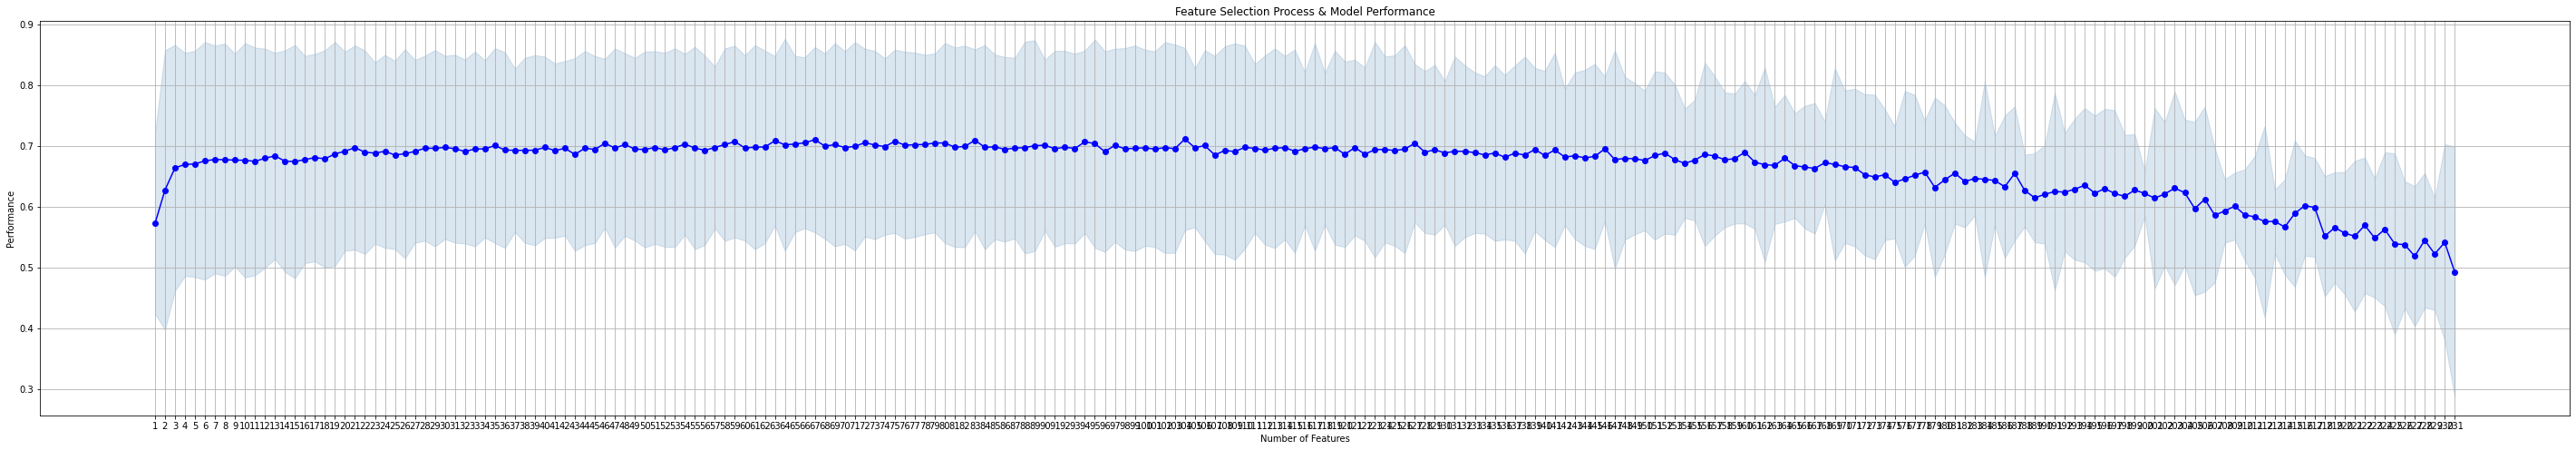

In [21]:
model.plot_feature_selection(figsize=(50, 8))

In [22]:
best_features_df = pd.DataFrame.from_dict(model.clf.named_steps['feature_selection'].get_metric_dict()).T
best_features_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(228,)","[0.513137197379266, 0.5298160556665164, 0.5122...",0.571671,"(228,)",0.148309,0.092521,0.053417
2,"(223, 228)","[0.4605939957811212, 0.520559242316861, 0.8187...",0.626818,"(223, 228)",0.229851,0.14339,0.082786
3,"(222, 223, 228)","[0.49428635290501943, 0.5971103666000902, 0.82...",0.6633,"(222, 223, 228)",0.202439,0.126289,0.072913
4,"(44, 222, 223, 228)","[0.5061509017504157, 0.621744732942465, 0.8020...",0.669068,"(44, 222, 223, 228)",0.183536,0.114497,0.066105
5,"(44, 220, 222, 223, 228)","[0.5157523434334967, 0.6136975710327943, 0.824...",0.66986,"(44, 220, 222, 223, 228)",0.186159,0.116133,0.067049
6,"(19, 44, 220, 222, 223, 228)","[0.5119832921224313, 0.6171509567682495, 0.836...",0.674966,"(19, 44, 220, 222, 223, 228)",0.195467,0.121939,0.070402
7,"(10, 19, 44, 220, 222, 223, 228)","[0.5155288266767248, 0.6305167192835514, 0.829...",0.677203,"(10, 19, 44, 220, 222, 223, 228)",0.187262,0.116821,0.067447
8,"(10, 19, 44, 167, 220, 222, 223, 228)","[0.5121788692846067, 0.6251111397461504, 0.827...",0.67683,"(10, 19, 44, 167, 220, 222, 223, 228)",0.191151,0.119247,0.068848
9,"(10, 19, 44, 141, 167, 220, 222, 223, 228)","[0.5302054957182571, 0.6199520005154308, 0.815...",0.676154,"(10, 19, 44, 141, 167, 220, 222, 223, 228)",0.175251,0.109328,0.063121
10,"(10, 19, 44, 141, 157, 167, 220, 222, 223, 228)","[0.5119553525278348, 0.6187890599832485, 0.827...",0.675935,"(10, 19, 44, 141, 157, 167, 220, 222, 223, 228)",0.192851,0.120308,0.06946


In [24]:
model.X_transformed_features[[best_features_df.iloc[5]['feature_idx']]]

array(['cat__pair_copy_BADGER/USDT', 'cat__pair_copy_DGB/USDT',
       'remainder__trend_kst_diff_berk_1d',
       'remainder__trend_mass_index_berk_1d',
       'remainder__volatility_kcw_berk_1d',
       'remainder__trend_mass_index_ark_1d'], dtype=object)

In [25]:
top_features = []
prev_features = []

for k, v in model.clf.named_steps['feature_selection'].subsets_.items():
    current_features = list(v['feature_idx'])
    current_features = [i for i in current_features if i not in prev_features]
    top_features += current_features
    print(top_features)
    prev_features = list(v['feature_idx'])

[228]
[228, 223]
[228, 223, 222]
[228, 223, 222, 44]
[228, 223, 222, 44, 220]
[228, 223, 222, 44, 220, 19]
[228, 223, 222, 44, 220, 19, 10]
[228, 223, 222, 44, 220, 19, 10, 167]
[228, 223, 222, 44, 220, 19, 10, 167, 141]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136, 118]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136, 118, 29]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136, 118, 29, 164]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136, 118, 29, 164, 97]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136, 118, 29, 164, 97, 229]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136, 118, 29, 164, 97, 229, 187]
[228, 223, 222, 44, 220, 19, 10, 167, 141, 157, 69, 75, 136, 118, 29, 164, 97, 229, 187, 219]
[228,

In [32]:
model.X_transformed_features[[top_features[:200]]]

array(['remainder__trend_mass_index_ark_1d',
       'remainder__volatility_kcw_berk_1d',
       'remainder__trend_mass_index_berk_1d', 'cat__pair_copy_DGB/USDT',
       'remainder__trend_kst_diff_berk_1d', 'cat__pair_copy_BADGER/USDT',
       'cat__pair_copy_ARDR/USDT', 'cat__pair_copy_XVS/USDT',
       'cat__pair_copy_TFUEL/USDT', 'cat__pair_copy_WAVES/USDT',
       'cat__pair_copy_HIVE/USDT', 'cat__pair_copy_IOTX/USDT',
       'cat__pair_copy_STRAX/USDT', 'cat__pair_copy_REEF/USDT',
       'cat__pair_copy_CAKE/USDT', 'cat__pair_copy_XMR/USDT',
       'cat__pair_copy_NBS/USDT', 'remainder__volatility_kcw_ark_1d',
       'remainder__volume_vwap_btc_12h',
       'remainder__trend_macd_diff_berk_1d', 'cat__pair_copy_CKB/USDT',
       'cat__pair_copy_ANT/USDT', 'cat__pair_copy_RIF/USDT',
       'remainder__trend_psar_down_indicator',
       'cat__pair_copy_SUSHI/USDT', 'remainder__momentum_kama_ark_1d',
       'cat__pair_copy_RUNE/USDT',
       'remainder__momentum_pvo_signal_btc_12h',
  

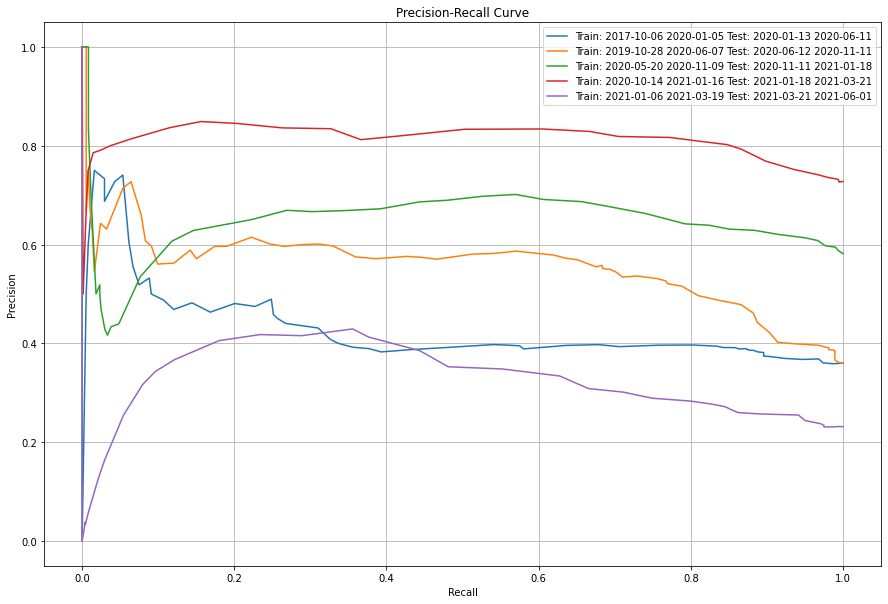

In [25]:
model.plot_precision_recall_curve()

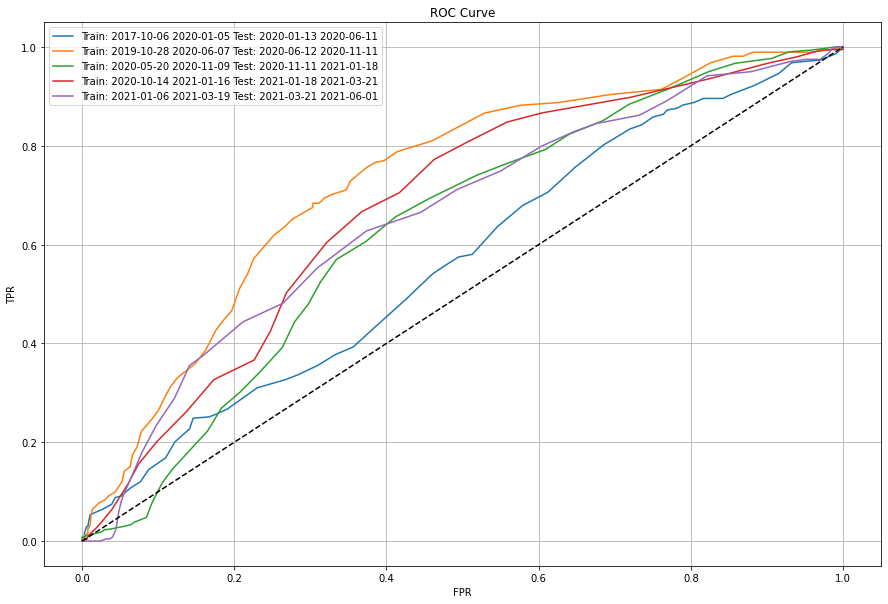

In [26]:
model.plot_roc_curve()

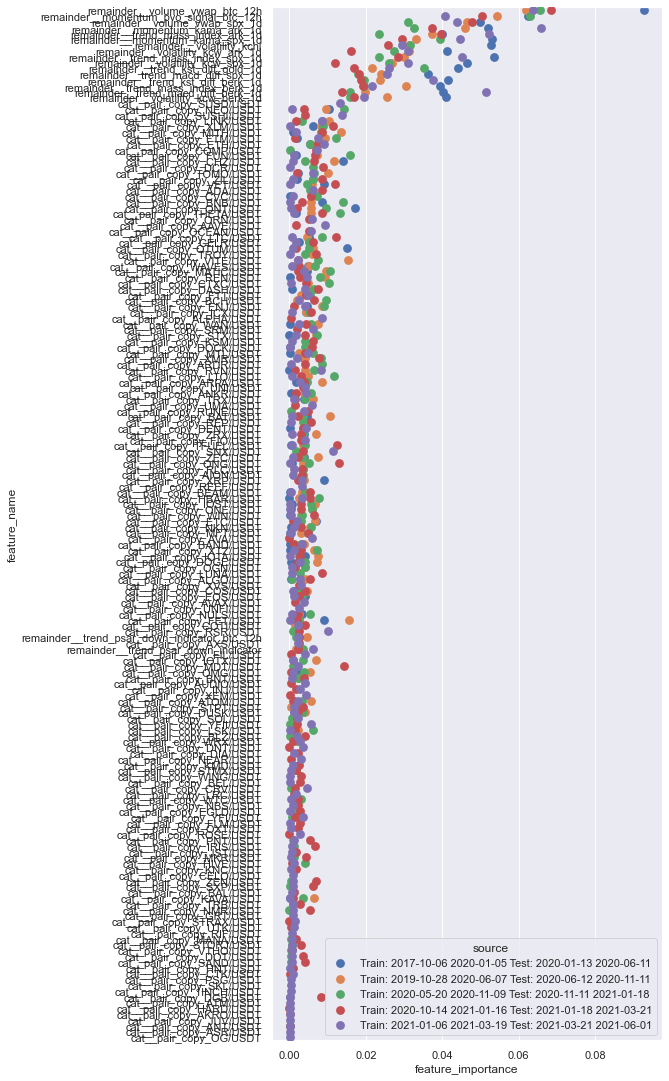

In [27]:
model.plot_feature_importance()

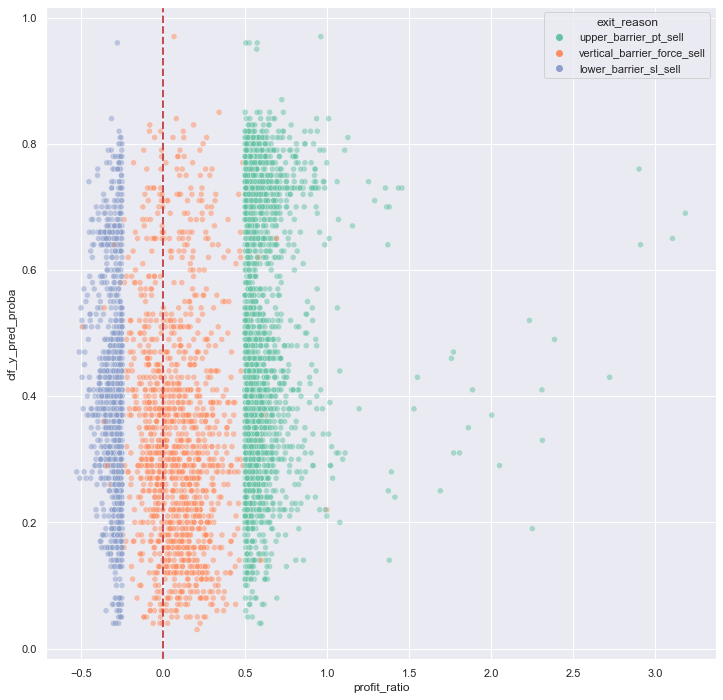

In [28]:
model.plot_probability_returns_scatter()

In [ ]:
model.probability_returns_table()

In [29]:
model.run_train_on_all_data()

In [ ]:
model.plot_feature_importance()

In [ ]:
model.model_threshold_table()

In [30]:
model.set_model_threshold(model_threshold=0.5)

In [31]:
model.save_model(filename='VulcanMeta.pkl')

# Appendix / Testing (to be deleted)

In [ ]:
model.data['clf_y_pred_proba'].hist()

In [ ]:
model.clf.predict_proba(model.data[model.X_features])[:, 1]

In [ ]:
test = model.data.iloc[0:3, :][model.X_features]
test

In [ ]:
nan_test = model.data.iloc[0:3, :][model.X_features].copy()
nan_test[:] = np.nan
nan_test

In [ ]:
model.clf.predict_proba(nan_test)[:, 1]

In [ ]:
some_nan_test = model.data.iloc[0:3, :][model.X_features].copy()
some_nan_test.iloc[:, 3] = np.nan
some_nan_test

In [ ]:
model.clf.predict_proba(some_nan_test)[:, 1]

In [ ]:
ii = mm.InfinityImputer()

In [ ]:
ii.transform(some_nan_test)

In [ ]:
np.nan_to_num(some_nan_test, copy=False)

In [ ]:
some_nan_test.fillna(999)

In [ ]:
np.where(pd.isna(nan_test), 999, some_nan_test)

In [ ]:
np.isinf(nan_test)

In [ ]:
w = np.where(pd.isna(some_nan_test.values), 999, some_nan_test.values)
w

In [ ]:
df.to_csv('all_long_trades_vulcan.csv')

In [ ]:
df.groupby('open_date').size().plot()

In [ ]:
df.groupby('open_date')['pair_copy'].nunique().plot()

In [ ]:
df.loc[idx[:, :, '2019-01-01':'2021-06-01']]